In [ ]:
#!/usr/bin/env python

"""clip_classes.py: Contains the CLIPDataset and CLIPTrainer wrapper"""

__author__ = "Christoper Alexander"
__copyright__ = "Copyright 2023"
__credits__ = ["Andrew D'Amico", "Christoper Alexander", "Katya Nosulko", "Vivek Chamala", "Matthew Conger"]
__license__ = ""
__version__ = "0.0.1"
__maintainer__ = "Andrew Damico"
__email__ = "andrew.damico@u.northwestern.edu"

In [1]:
from enum import Enum
from typing import Tuple, Optional

# import clip
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from PIL import Image
from torch.nn import functional as nnf
from transformers import AutoProcessor, CLIPModel, pipeline
from transformers import GPT2Tokenizer, GPT2LMHeadModel

/opt/conda/envs/transformers/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup

In [2]:
device = torch.device("cuda")

In [3]:
clip_checkpoint = "radCLIP2_p"

In [4]:
llm_checkpoint = "gptmedium_10k"

In [5]:
mapper_checkpoint = "clip_caption_model_transformer_10k_new"

## Mapping Model Components

In [6]:
class MappingType(Enum):
    MLP = 'mlp'
    Transformer = 'transformer'

In [7]:
class MLP(nn.Module):
    def __init__(self, sizes: Tuple[int, ...], bias=True, act=nn.Tanh):
        super(MLP, self).__init__()
        layers = []
        for i in range(len(sizes) - 1):
            layers.append(nn.Linear(sizes[i], sizes[i + 1], bias=bias))
            if i < len(sizes) - 2:
                layers.append(act())
        self.model = nn.Sequential(*layers)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)


class MlpTransformer(nn.Module):
    def __init__(self, in_dim, h_dim, out_d: Optional[int] = None, act=nnf.relu, dropout=0.):
        super().__init__()
        out_d = out_d if out_d is not None else in_dim
        self.fc1 = nn.Linear(in_dim, h_dim)
        self.act = act
        self.fc2 = nn.Linear(h_dim, out_d)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        return x

In [8]:
class MultiHeadAttention(nn.Module):

    def __init__(self, dim_self, dim_ref, num_heads, bias=True, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        head_dim = dim_self // num_heads
        self.scale = head_dim ** -0.5
        self.to_queries = nn.Linear(dim_self, dim_self, bias=bias)
        self.to_keys_values = nn.Linear(dim_ref, dim_self * 2, bias=bias)
        self.project = nn.Linear(dim_self, dim_self)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, y=None, mask=None):
        y = y if y is not None else x
        b, n, c = x.shape
        _, m, d = y.shape
        # b n h dh
        queries = self.to_queries(x).reshape(b, n, self.num_heads, c // self.num_heads)
        # b m 2 h dh
        keys_values = self.to_keys_values(y).reshape(b, m, 2, self.num_heads, c // self.num_heads)
        keys, values = keys_values[:, :, 0], keys_values[:, :, 1]
        attention = torch.einsum('bnhd,bmhd->bnmh', queries, keys) * self.scale
        if mask is not None:
            if mask.dim() == 2:
                mask = mask.unsqueeze(1)
            attention = attention.masked_fill(mask.unsqueeze(3), float("-inf"))
        attention = attention.softmax(dim=2)
        out = torch.einsum('bnmh,bmhd->bnhd', attention, values).reshape(b, n, c)
        out = self.project(out)
        return out, attention

In [9]:
class TransformerLayer(nn.Module):
    def __init__(self, dim_self, dim_ref, num_heads, mlp_ratio=4., bias=False, dropout=0., act=nnf.relu,
                 norm_layer: nn.Module = nn.LayerNorm):
        super().__init__()
        self.norm1 = norm_layer(dim_self)
        self.attn = MultiHeadAttention(dim_self, dim_ref, num_heads, bias=bias, dropout=dropout)
        self.norm2 = norm_layer(dim_self)
        self.mlp = MlpTransformer(dim_self, int(dim_self * mlp_ratio), act=act, dropout=dropout)

    def forward_with_attention(self, x, y=None, mask=None):
        x_, attention = self.attn(self.norm1(x), y, mask)
        x = x + x_
        x = x + self.mlp(self.norm2(x))
        return x, attention

    def forward(self, x, y=None, mask=None):
        x = x + self.attn(self.norm1(x), y, mask)[0]
        x = x + self.mlp(self.norm2(x))
        return x

In [10]:
class Transformer(nn.Module):
    def __init__(self, dim_self: int, num_heads: int, num_layers: int, dim_ref: Optional[int] = None,
                 mlp_ratio: float = 2., act=nnf.relu, norm_layer: nn.Module = nn.LayerNorm, enc_dec: bool = False):
        super(Transformer, self).__init__()
        dim_ref = dim_ref if dim_ref is not None else dim_self
        self.enc_dec = enc_dec
        if enc_dec:
            num_layers = num_layers * 2
        layers = []
        for i in range(num_layers):
            if i % 2 == 0 and enc_dec:  # cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            elif enc_dec:  # self
                layers.append(
                    TransformerLayer(dim_self, dim_self, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
            else:  # self or cross
                layers.append(TransformerLayer(dim_self, dim_ref, num_heads, mlp_ratio, act=act, norm_layer=norm_layer))
        self.layers = nn.ModuleList(layers)

    def forward_with_attention(self, x, y=None, mask=None):
        attentions = []
        for layer in self.layers:
            x, att = layer.forward_with_attention(x, y, mask)
            attentions.append(att)
        return x, attentions

    def forward(self, x, y=None, mask=None):
        for i, layer in enumerate(self.layers):
            if i % 2 == 0 and self.enc_dec:  # cross
                x = layer(x, y)
            elif self.enc_dec:  # self
                x = layer(x, x, mask)
            else:  # self or cross
                x = layer(x, y, mask)
        return x

In [11]:
class TransformerMapper(nn.Module):
    def __init__(self, dim_clip: int, dim_embedding: int, prefix_length: int, clip_length: int, num_layers: int = 8):
        super(TransformerMapper, self).__init__()
        self.clip_length = clip_length
        self.transformer = Transformer(dim_embedding, 8, num_layers)
        self.linear = nn.Linear(dim_clip, clip_length * dim_embedding)
        self.prefix_const = nn.Parameter(torch.randn(prefix_length, dim_embedding), requires_grad=True)

    def forward(self, x):
        x = self.linear(x).view(x.shape[0], self.clip_length, -1)
        prefix = self.prefix_const.unsqueeze(0).expand(x.shape[0], *self.prefix_const.shape)
        prefix = torch.cat((x, prefix), dim=1)
        out = self.transformer(prefix)[:, self.clip_length:]
        return out

In [12]:
class ClipCaptionModel(nn.Module):
    def __init__(self, prefix_length: int, clip_length: Optional[int] = None, prefix_size: int = 512,
                 num_layers: int = 8, mapping_type: MappingType = MappingType.MLP):
        super(ClipCaptionModel, self).__init__()
        self.prefix_length = prefix_length
        self.gpt = GPT2LMHeadModel.from_pretrained('gptmedium_10k')
        self.gpt_embedding_size = self.gpt.transformer.wte.weight.shape[1]
        if mapping_type == MappingType.MLP:
            self.clip_project = MLP((prefix_size, (self.gpt_embedding_size * prefix_length) // 2,
                                     self.gpt_embedding_size * prefix_length))
        else:
            self.clip_project = TransformerMapper(prefix_size, self.gpt_embedding_size, prefix_length,
                                                  clip_length, num_layers)

    def get_dummy_token(self, batch_size: int, device: torch.device) -> torch.Tensor:
        return torch.zeros(batch_size, self.prefix_length, dtype=torch.int64, device=device)

    def forward(self, tokens: torch.Tensor, prefix: torch.Tensor, mask: Optional[torch.Tensor] = None,
                labels: Optional[torch.Tensor] = None):
        embedding_text = self.gpt.transformer.wte(tokens)
        prefix_projections = self.clip_project(prefix).view(-1, self.prefix_length, self.gpt_embedding_size)
        embedding_cat = torch.cat((prefix_projections, embedding_text), dim=1)
        if labels is not None:
            dummy_token = self.get_dummy_token(tokens.shape[0], tokens.device)
            labels = torch.cat((dummy_token, tokens), dim=1)
        out = self.gpt(inputs_embeds=embedding_cat, labels=labels, attention_mask=mask)
        return out

In [13]:
def generate_beam(
        model,
        tokenizer,
        beam_size: int = 5,
        prompt=None,
        embed=None,
        entry_length=67,
        temperature=1.0,
        stop_token: str = ".",
):
    model.eval()
    stop_token_index = tokenizer.encode(stop_token)[0]
    tokens = None
    scores = None
    device = next(model.parameters()).device
    seq_lengths = torch.ones(beam_size, device=device)
    is_stopped = torch.zeros(beam_size, device=device, dtype=torch.bool)
    with torch.no_grad():
        if embed is not None:
            generated = embed
        else:
            if tokens is None:
                tokens = torch.tensor(tokenizer.encode(prompt))
                tokens = tokens.unsqueeze(0).to(device)
                generated = model.gpt.transformer.wte(tokens)
        for i in range(entry_length):
            outputs = model.gpt(inputs_embeds=generated)
            logits = outputs.logits
            logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
            logits = logits.softmax(-1).log()
            if scores is None:
                scores, next_tokens = logits.topk(beam_size, -1)
                generated = generated.expand(beam_size, *generated.shape[1:])
                next_tokens, scores = next_tokens.permute(1, 0), scores.squeeze(0)
                if tokens is None:
                    tokens = next_tokens
                else:
                    tokens = tokens.expand(beam_size, *tokens.shape[1:])
                    tokens = torch.cat((tokens, next_tokens), dim=1)
            else:
                logits[is_stopped] = -float(np.inf)
                logits[is_stopped, 0] = 0
                scores_sum = scores[:, None] + logits
                seq_lengths[~is_stopped] += 1
                scores_sum_average = scores_sum / seq_lengths[:, None]
                scores_sum_average, next_tokens = scores_sum_average.view(-1).topk(
                    beam_size, -1
                )
                next_tokens_source = next_tokens // scores_sum.shape[1]
                seq_lengths = seq_lengths[next_tokens_source]
                next_tokens = next_tokens % scores_sum.shape[1]
                next_tokens = next_tokens.unsqueeze(1)
                tokens = tokens[next_tokens_source]
                tokens = torch.cat((tokens, next_tokens), dim=1)
                generated = generated[next_tokens_source]
                scores = scores_sum_average * seq_lengths
                is_stopped = is_stopped[next_tokens_source]
            next_token_embed = model.gpt.transformer.wte(next_tokens.squeeze()).view(
                generated.shape[0], 1, -1
            )
            generated = torch.cat((generated, next_token_embed), dim=1)
            is_stopped = is_stopped + next_tokens.eq(stop_token_index).squeeze()
            if is_stopped.all():
                break
    scores = scores / seq_lengths
    output_list = tokens.cpu().numpy()
    output_texts = [
        tokenizer.decode(output[: int(length)])
        for output, length in zip(output_list, seq_lengths)
    ]
    order = scores.argsort(descending=True)
    output_texts = [output_texts[i] for i in order]
    return output_texts

In [14]:
def generate2(
        model,
        tokenizer,
        tokens=None,
        prompt=None,
        embed=None,
        entry_count=1,
        entry_length=67,  # maximum number of words
        top_p=0.8,
        temperature=0.9,
        stop_token: str = ".",
):
    model.eval()
    generated_num = 0
    generated_list = []
    stop_token_index = tokenizer.encode(stop_token)[0]
    filter_value = -float("Inf")
    device = next(model.parameters()).device

    with torch.no_grad():

        for entry_idx in range(entry_count):
            if embed is not None:
                generated = embed
            else:
                if tokens is None:
                    tokens = torch.tensor(tokenizer.encode(prompt))
                    tokens = tokens.unsqueeze(0).to(device)

                generated = model.gpt.transformer.wte(tokens)

            for i in range(entry_length):

                outputs = model.gpt(inputs_embeds=generated)
                logits = outputs.logits
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)
                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(
                    nnf.softmax(sorted_logits, dim=-1), dim=-1
                )
                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                                                    ..., :-1
                                                    ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value
                next_token = torch.argmax(logits, -1).unsqueeze(0)
                next_token_embed = model.gpt.transformer.wte(next_token)
                if tokens is None:
                    tokens = next_token
                else:
                    tokens = torch.cat((tokens, next_token), dim=1)
                generated = torch.cat((generated, next_token_embed), dim=1)
                if stop_token_index == next_token.item():
                    break

            output_list = list(tokens.squeeze().cpu().numpy())
            output_text = tokenizer.decode(output_list)
            generated_list.append(output_text)

    return generated_list[0]

## Full Model

In [15]:
class MedicalImageChatBot:
    def __init__(
            self,
            device,
            clip_checkpoint,
            llm_checkpoint,
            mapper_checkpoint,
            prefix_length=10,
            clip_length=10,
            prefix_size=512,
            num_layers=8,
            mapping_type=MappingType.Transformer
    ):
        self.device = device
        self.prefix_length = prefix_length
        self.clip_model = CLIPModel.from_pretrained(clip_checkpoint).to(device)
        self.processor = AutoProcessor.from_pretrained("openai/clip-vit-base-patch32")
        self.mapper_model = ClipCaptionModel(
            prefix_length,
            clip_length=clip_length,
            prefix_size=prefix_size,
            num_layers=num_layers,
            mapping_type=mapping_type
        )
        self.mapper_model.load_state_dict(torch.load(mapper_checkpoint, map_location=torch.device("cpu")))
        self.mapper_model = self.mapper_model.eval()
        self.mapper_model = self.mapper_model.to(device)
        self.llm_tokenizer = GPT2Tokenizer.from_pretrained(llm_checkpoint)
        self.llm_model = GPT2LMHeadModel.from_pretrained(llm_checkpoint)
        self.llm_pipeline = pipeline('text-generation', model=self.llm_model, tokenizer=self.llm_tokenizer)

    def process_image(self,
                      image_fn,
                      captions=None,
                      caption_temp=1.0,
                      llm_temp=1.0,
                      num_return_sequences=1,
                      top_k=50,
                      top_p=0.95,
                      max_length=300
                      ):
        if captions is None:
            inputs = self.processor(
                images=Image.open(image_fn),
                return_tensors="pt"
            ).to(self.device)
            with torch.no_grad():
                prefix = self.clip_model.get_image_features(**inputs).to(self.device)
                prefix_embed = self.mapper_model.clip_project(prefix).reshape(1, self.prefix_length, -1)

            captions = generate_beam(
                self.mapper_model, self.llm_tokenizer, embed=prefix_embed, temperature=caption_temp
            )
            print(captions)
        else:
            inputs = self.processor(
                images=Image.open(image_fn),
                text=captions,
                return_tensors="pt",
                padding=True
            )
            with torch.no_grad():
                outputs = self.clip_model(**inputs)

            logits_per_image = outputs.logits_per_image
            probs = logits_per_image.softmax(dim=1)
            # TODO: select highest prob

        generated_text = self.llm_pipeline(
            f"The finding on the x-ray is that {captions[0]} This suggests",
            max_length=max_length,
            num_return_sequences=num_return_sequences,
            do_sample=True,
            top_k=top_k,
            top_p=top_p,
            temperature=llm_temp
            # num_beams=3
        )

        return generated_text

In [16]:
full_model = MedicalImageChatBot(
    device,
    clip_checkpoint,
    llm_checkpoint,
    mapper_checkpoint
)

You are using a model of type clip_vision_model to instantiate a model of type clip. This is not supported for all configurations of models and can yield errors.
Some weights of CLIPModel were not initialized from the model checkpoint at radCLIP2_p and are newly initialized: ['text_model.encoder.layers.7.layer_norm2.weight', 'text_model.encoder.layers.6.layer_norm1.bias', 'text_model.encoder.layers.0.self_attn.k_proj.bias', 'text_model.encoder.layers.4.self_attn.v_proj.bias', 'text_model.encoder.layers.7.self_attn.q_proj.weight', 'text_model.encoder.layers.3.self_attn.q_proj.bias', 'visual_projection.weight', 'text_model.encoder.layers.8.self_attn.out_proj.weight', 'text_model.encoder.layers.2.mlp.fc2.bias', 'text_model.encoder.layers.8.layer_norm2.bias', 'text_model.encoder.layers.10.mlp.fc1.bias', 'text_model.encoder.layers.10.self_attn.k_proj.weight', 'text_model.encoder.layers.3.self_attn.k_proj.bias', 'logit_scale', 'text_model.encoder.layers.11.self_attn.q_proj.bias', 'text_model

In [17]:
df = pd.read_csv("ALL_PAIRS.csv")
combined_data = df[df["candidate"] == True][["value", "file_name"]].groupby("file_name")["value"].apply(list)

In [18]:
folder = "resized"

In [19]:
idx = 44444

In [20]:
combined_data[idx]

['the tip of the tube projects cm above the carina.',
 'the other monitoring and support devices are constant.',
 'constant bilateral pleural effusions and extensive parenchymal atelectasis, predominantly suggesting pulmonary edema.',
 'these opacities are minimally improved as compared to the prior image.']

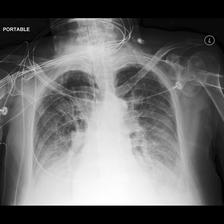

In [21]:
Image.open(f"{folder}/{combined_data.index[idx]}")

In [23]:
full_model.process_image(
    f"{folder}/{combined_data.index[idx]}",
    caption_temp=1.1,
    llm_temp=0.9,
    top_k=45,
    top_p=0.9,
    num_return_sequences=2,
    max_length=100
)

['cardiomediastinal silhouette is within normal limits.', 'there is no pneumothorax.', 'cardiomediastinal silhouette is unchanged.', 'no pneumothorax.', 'cardiomediastinal silhouette is stable.']


[{'generated_text': 'The finding on the x-ray is that cardiomediastinal silhouette is within normal limits. This suggests that our patient’s cardiac enlargement was not due to a tumor in the mediastinum. Our patient was in good health before the initial symptoms began. However, the cardiac enlargement appeared more significant as the disease progressed and was accompanied by significant weight loss. This is consistent with the findings of previous studies and suggests that cardiac enlargement may be caused by cardiomy'},
 {'generated_text': 'The finding on the x-ray is that cardiomediastinal silhouette is within normal limits. This suggests a good likelihood of a benign diagnosis. The x-ray is not used as a first-line investigation of this case as it is time consuming. As the patient is a young man, the x-ray does not reveal significant changes. The diagnostic value of an x-ray remains controversial. Some studies show that a chest x-ray can be valuable in differentiating between cardia

In [70]:
generated_text = full_model.llm_pipeline(
    "The finding on the x-ray is that cardiomediastinal silhouette is within normal limits.  This suggests",
    max_length=100,
    num_return_sequences=2,
    do_sample=True,
    top_k=45,
    top_p=0.9,
    temperature=0.9,
)

In [71]:
generated_text[0]["generated_text"]

'The finding on the x-ray is that cardiomediastinal silhouette is within normal limits.  This suggests that the patient had a normal chest x-ray, and the CT scan did not show any signs of cardiac enlargement, which would be the case if the patient had had cardiac tamponade. The patient’s condition improved after she was transferred to a general surgery department. A cardiac tamponade, as with many complications, can present as an asymptomatic'

In [72]:
generated_text[1]["generated_text"]

'The finding on the x-ray is that cardiomediastinal silhouette is within normal limits.  This suggests that the X-ray image is in fact a real and valid image for the determination of cardiac size, and is a clear proof of concept that the technique can be used by a thoracic surgeon to determine cardiac size in a patient with heart disease. A few limitations of the study include the relatively small sample size of patients and the relatively small number of cases, which prevented a'